----
# Loading [Amigos data][Amigos data] into numpy arrays

### Important labels:
* VideoIDs
* joined_data
* labels_ext_annotation
* labels_selfassessment

[Amigos data]: <http://www.eecs.qmul.ac.uk/mmv/datasets/amigos/readme.html#prep>

In [1]:
import os
import sys
import scipy.io
import numpy as np
from tqdm import tqdm
from IPython.terminal.embed import InteractiveShellEmbed

ip_shell = InteractiveShellEmbed()
origin_path = ip_shell.magic("%pwd")

amigos_database_folder_name = "amigos"
amigos_folder = os.path.join(origin_path, amigos_database_folder_name)  # Folder that stores all amigos db data

preprocessed_data_folder = os.path.join(amigos_folder, "Data_Preprocessed")
preprocessed_data_files = [os.path.join(preprocessed_data_folder, name) for name
                            in os.listdir(preprocessed_data_folder) if name.split(".")[-1].lower() == "mat"]

# Loading data form files into list
data_to_preprocess = []
for index in tqdm(range(len(preprocessed_data_files))):
    file_path = preprocessed_data_files[index]  
    work_file = scipy.io.loadmat(file_path)
    data_to_preprocess.append(work_file)
    file_name = file_path.split('\\')[-1]

# Removal of non-valid data according to paper
ids_to_remove = [33, 24, 23, 22, 21, 12, 9]
for id_to_remove in ids_to_remove:
    data_to_preprocess.pop(id_to_remove)

100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


In [2]:
import numpy as np

patient_recorded_data = []
video_id_data = []
self_assesment_data = []
external_annotation_data = []
ECG_columns = [14, 15]

# Loading data into lists
for patient in data_to_preprocess:
    video_list = [video_id[0] for video_id in patient['VideoIDs'][0]]
    video_id_data.append(video_list)
    
    self_assesment = patient['labels_selfassessment'][0]
    self_assesment_matrix = np.zeros((len(self_assesment), len(self_assesment[0][0])), dtype=float)
    for row_index, video in enumerate(self_assesment):
        for col_index, value in enumerate(video[0]):
            self_assesment_matrix[row_index, col_index] = value
    self_assesment_data.append(self_assesment_matrix)
    
    external_annotation_data.append(list(patient['labels_ext_annotation'][0]))
    
    patient_recorded_data.append(list(patient['joined_data'][0]))
    
for pat_id, patient in enumerate(patient_recorded_data):
    videos_to_pop = [-1,-2,-3,-4] #last 4 videos are long videos we want to omit
    for index, video_ECG in enumerate(patient):
        if video_ECG.shape[0] == 0:
            videos_to_pop.append(index)
    
    if videos_to_pop:
        videos_to_pop.reverse()
        for video in videos_to_pop:
            patient.pop(video)
            print(f"Removing empty record \tPatient: {pat_id : >2} \tVideo: {video : >2}")

# Just ECG data
ECG_data = []
for patient in patient_recorded_data:
    patient_ECG = []
    for video in patient:
        patient_ECG.append(video[:, ECG_columns])
    ECG_data.append(patient_ECG)

# ECG_data = patient_recorded_data

Removing empty record 	Patient:  0 	Video: -4
Removing empty record 	Patient:  0 	Video: -3
Removing empty record 	Patient:  0 	Video: -2
Removing empty record 	Patient:  0 	Video: -1
Removing empty record 	Patient:  1 	Video: -4
Removing empty record 	Patient:  1 	Video: -3
Removing empty record 	Patient:  1 	Video: -2
Removing empty record 	Patient:  1 	Video: -1
Removing empty record 	Patient:  2 	Video: -4
Removing empty record 	Patient:  2 	Video: -3
Removing empty record 	Patient:  2 	Video: -2
Removing empty record 	Patient:  2 	Video: -1
Removing empty record 	Patient:  3 	Video: -4
Removing empty record 	Patient:  3 	Video: -3
Removing empty record 	Patient:  3 	Video: -2
Removing empty record 	Patient:  3 	Video: -1
Removing empty record 	Patient:  4 	Video: 19
Removing empty record 	Patient:  4 	Video: 18
Removing empty record 	Patient:  4 	Video: 17
Removing empty record 	Patient:  4 	Video: 16
Removing empty record 	Patient:  4 	Video: -4
Removing empty record 	Patient:  4

----
## Data accessing
* __video_id_data (a) (b)__ - _list of used videos (total of 20 elements)_
    > a - patient ID  
    
* __self_assesment_data (a)__ - _matrix of 20 rows and 12 columns_ 
    > a - patient ID  

* __external_annotation_data (a) (b)__ - _matrix of X1 rows and 3 columns_
    > a - patient ID  
    > b - video sample index
    
* __ECG_data (a) (b)__ - _matrix of X2 rows and 17 columns_
    > a - patient ID  
    > b - video sample index
    

In [3]:
# Definition of functions
import math
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


def compare_two_ECG(data: list, patients=(0,1), time=(0,5), video=0, ECG=0, fig_size=(15,7),
                    sampling_frequency=128, colors=("b","r")):
    """
    Compares selected ECG data for two selected patiens
    
    :param data: ECG data list
    :param patients: tuple representing two selected patients
    :param time: tuple defineing start and end of the plot time axis
    :param video: selected video id
    :param ECG: selected ECG plot
    :param fig_size: size of the figure
    """
    
    sampling_frequency = 128
    patient_1 = data[patients[0]]
    patient_2 = data[patients[1]]
    
    X = np.arange(patient_1[video].shape[0])
    fig = plt.figure(figsize=fig_size)
    ax1 = fig.add_subplot(111)
    
    # Results for patient 1
    ax1.plot(X[time[0]*sampling_frequency:time[1]*sampling_frequency], 
             patient_1[video][:,ECG][time[0]*sampling_frequency:time[1]*sampling_frequency],
             color=colors[0], linewidth="0.75", label="Patient 1")
    
    # Results for patient 2
    ax1.plot(X[time[0]*sampling_frequency:time[1]*sampling_frequency], 
             patient_2[video][:,ECG][time[0]*sampling_frequency:time[1]*sampling_frequency],
             color=colors[1], linewidth="0.75", label="Patient 2")
    
    # Horizontal axis at y=0
    ax1.axhline(0, linewidth=1, color="k")
    plt.legend(fontsize=15)
    plt.show()
    

def compare_two_samples(data: list, patients=(0,1), time=(0,1), video=0, ECG=0, sample=0, fig_size=(15,7),
                    sampling_frequency=128, colors=("b","r")):
    """
    Compares selected sample ECG data for two selected patiens
    
    :param data: ECG data list
    :param patients: tuple representing two selected patients
    :param time: tuple defineing start and end of the plot time axis
    :param video: selected video id
    :param sample: number of ECG sample
    :param ECG: selected ECG plot
    :param fig_size: size of the figure
    """
    
    sampling_frequency = 128
    patient_1 = data[patients[0]]
    patient_2 = data[patients[1]]
    
    X = np.arange(patient_1[video][sample].shape[0])
    fig = plt.figure(figsize=fig_size)
    ax1 = fig.add_subplot(111)
    
    # Results for patient 1
    ax1.plot(X[time[0]*sampling_frequency:time[1]*sampling_frequency], 
             patient_1[video][sample][:,ECG][time[0]*sampling_frequency:time[1]*sampling_frequency],
             color=colors[0], linewidth="0.75", label="Patient 1")
    
    # Results for patient 2
    ax1.plot(X[time[0]*sampling_frequency:time[1]*sampling_frequency], 
             patient_2[video][sample][:,ECG][time[0]*sampling_frequency:time[1]*sampling_frequency],
             color=colors[1], linewidth="0.75", label="Patient 2")
    
    # Horizontal axis at y=0
    ax1.axhline(0, linewidth=1, color="k")
    plt.legend(fontsize=15)
    plt.show()
    
    
def plot_all_ECG_results(data: list, patient_ids=(0,), video=0, color=('r','b','g','c', 'y'), columns=2):
    """
    Draws plot comparasion for each patient listed in patient_ids
    
    :param data: ECG data list
    :param patient_ids: list of patient ids to plot from
    :param video: video selected for comparasion
    :param color: list of colors to be used
    :param columns: number of subplot columns
    :return: None
    """
    
    number_of_data_columns = len(data[patient_ids[0]][video][0])
    rows = math.ceil(number_of_data_columns/columns)  # Number of subplot rows
    fig, axs = plt.subplots(rows, columns, figsize=(8*columns, 3*rows))  # Generation of subplot
    
    for patient_number, patient_id in enumerate(patient_ids):
        ECG_records = data[patient_id]
        X = np.arange(ECG_records[video].shape[0])  # X axis vector

        for data_index in range(number_of_data_columns):
            if rows > 1:
                axs[data_index//columns, data_index%columns].plot(X, ECG_records[video][:,data_index],
                                                                    color=color[patient_number], linewidth='0.75', 
                                                                    label=f"patient {patient_id}")  # Plot recorded values
                axs[data_index//columns, data_index%columns].axhline(0, linewidth=1, color='k')  # Horizontal line at y=0
            else:
                axs[data_index%columns].plot(X, ECG_records[video][:,data_index],
                                                                    color=color[patient_number], linewidth='0.75', 
                                                                    label=f"patient {patient_id}")  # Plot recorded values
                axs[data_index%columns].axhline(0, linewidth=1, color='k')  # Horizontal line at y=0

    # Remove empty plots
    if rows > 1:
        subplot_axes = [value for row in axs for value in row]  # List of all axes

        # Select only empty axes
        for ax in [value for index, value in enumerate(subplot_axes) if index >= number_of_data_columns]: 
            ax.remove()  # don't display empty axes

        handles, labels = axs[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', fontsize=25)

    else:
        subplot_axes = [value for value in axs]  # List of all axes

        # Select only empty axes
        for ax in [value for index, value in enumerate(subplot_axes) if index >= number_of_data_columns]: 
            ax.remove()  # don't display empty axes

        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right', fontsize=12)

    plt.show()
    
    
def trim_data(data: list, start_trim=2, end_trim=2, sampling_frequency=128) -> list:
    """
    Trims ECG data by given trim times
    
    :param data: ECG data list
    :param start_trim: time to be removed from the begginig of the data series in seconds
    :param end_trim: time to be removed from the end of the data series in seconds
    :param sampling_frequency: sampling frequency in Hz
    :return: trimed ECG data in list
    """
    
    trimmed_data = []
    for current_patient in data:
        video_data = []
        for current_video in current_patient:
            start_time = sampling_frequency * start_trim
            end_time = current_video.shape[0] - sampling_frequency * end_trim
            video_data.append(current_video[start_time:end_time])
        trimmed_data.append(video_data)
    return trimmed_data


def extract_data(data: list, start_time = 0, extract_time = 5, sampling_frequency=128) -> list:
    """
    Extract data from ECG data by given start time and time window
    
    :param data: ECG data list
    :param start_time: start time in seconds
    :param end_trim: number seconds to be extracted from data
    :param sampling_frequency: sampling frequency in Hz
    :return: list of extracted ECG data
    """
    
    extracted_data = []
    for current_patient in data:
        video_data = []
        for current_video in current_patient:
            start = int(start_time*sampling_frequency)
            end = int(start_time + sampling_frequency * extract_time)
            video_data.append(current_video[start:end,:])
        extracted_data.append(video_data)
    return extracted_data


def calculate_mean_over_data(data: list, calculation_frequency=1, sampling_frequency=128) -> list:
    """
    Calculates mean over data for given calculation frequency [seconds] and sampling frequency [Hz]
    :param data: ECG data list
    :param calculation_frequency: time window over which mean is calculated
    :param sampling_frequency: number of samples taken per second
    :return: averaged by given criteria ECG data list
    """
    
    calculated_baseline = []
    for current_patient in data:
        video_data = []
        for current_video in current_patient:
            number_of_splits = current_video.shape[0] // (sampling_frequency * calculation_frequency)
            split_positions = [(pos+1)*calculation_frequency*sampling_frequency for pos in range(number_of_splits)]
            current_data = np.split(current_video, split_positions)

            if current_data[-1].shape[0] == 0:  # Remove last row of splitted array if it's empty
                current_data.pop(len(current_data)-1)
            
            sample_data = []
            for sample in current_data:
                sample_data.append(np.mean(sample, axis=0))
                
            video_data.append(np.array(sample_data))
            
        calculated_baseline.append(video_data)   
    return calculated_baseline


def calculate_mean_baseline(data: list) -> list:
    """
    Calculates mean ECG signal from all the samples
    
    :param data: baseline ECG data list
    :return: single sample list of ECG data
    """
    
    splited_data = split_data_into_samples(data, sample_length=1)
    calculated_baseline_mean = []
    for patient in splited_data:
        video_data = []
        for video in patient:
            sample_data = np.zeros(video[0].shape, dtype=float)
            for sample in video:
                sample_data = np.add(sample_data, sample)
            video_data.append(sample_data)
        calculated_baseline_mean.append(video_data)
    return calculated_baseline_mean
            

def subtract_baseline_data(data: list, baseline_data:list) -> list:
    """
    Subtract baseline data from all corresponding elements of ECG data
    
    :param data: ECG data list
    :param baseline_data: list of baseline readings of ECG data size
    :return: ECG data list subtracted by corresponding baseline readings 
    """
    
    new_data = []
    for patient_index, patient in enumerate(data):
        video_data = []
        for video_index, video in enumerate(patient):
            sample_data = []
            for sample in video:
                sample_data.append(sample - baseline_data[patient_index][video_index][:sample.shape[0],:])
            video_data.append(sample_data)
        new_data.append(video_data)
    return new_data
    
    
def generate_baseline_subtraction_matrix(baseline_data: np.ndarray, size: tuple) -> np.ndarray:
    """
    Generates baseline matrix of the given shape by repeating baseline_data rows
    
    :param baseline_data: list of baseline reading from ECG_data
    :param size: tuple defining shape of output matrix
    :return: matrix of predefined sized
    """
    
    base_rows = baseline_data.shape[0]
    target_rows = size[0]
    repetitions = math.ceil(target_rows / base_rows)
    repetition_matrix = np.tile(baseline_data, (repetitions,1))
    return_matrix = repetition_matrix[:size[0], :size[1]]
    return return_matrix


def subtract_baseline_from_data(data: list, baseline: list) -> list:
    """
    Subtracts baseline reading from ECG reading
    
    :param data: ECG data list
    :param baseline: matrix of baseline readings of ECG data size
    :return: ECG data list subtracted by corresponding baseline readings 
    """
        
    new_data = []
    for patient_index, current_patient in enumerate(data):
        video_data = []
        for video_index, current_video in enumerate(current_patient):
            baseline_subtract = generate_baseline_subtraction_matrix(baseline[patient_index][video_index], 
                                                                 size=current_video.shape)
            video_data.append(current_video - baseline_subtract)
        new_data.append(video_data)
    return new_data


def split_data_into_samples(data: list, sample_length=1, sampling_frequency=128) -> list:
    """
    Split data int samples of specified length
    
    :param data: ECG data list
    :param sample_length: length of sample to use in seconds
    :param sampling_frequency: number of samples taken per second
    :return: list of samples taken from ECG data list
    """
    
    new_data = []
    for patient in data:
        video_data = []
        for video in patient:
            
            split_positions = [(pos+1)*sample_length*sampling_frequency for pos in range(
                video.shape[0] // (sampling_frequency * sample_length))]
            splited_data = np.split(video, split_positions)
            
            if splited_data[-1].shape[0] == 0:  # Remove last row of splitted array if it's empty
                splited_data.pop(len(splited_data)-1)  
            video_data.append(splited_data)
        new_data.append(video_data)
    return new_data
            

def zscore_normalize_data(data: list) -> list:
    """
    Performs zscale on the given ECG data
    
    :param data: ECG data list
    :return: Scaled ECG data list
    """
    
    # scaler = StandardScaler()
    new_data = []
    for index in tqdm(range(len(data))):
        patient = data[index]
        video_data = []
        for video in patient:
            sample_data = []
            for sample in video:
                u = np.mean(sample, axis=0)
                s = np.std(sample, axis=0)
                sample_data.append((sample - u ) / s)
                # Sklearn StandradScaler crashed on this data dunno why :(
                # transposed_sample = np.transpose(sample)
                # scaler.fit(list(transposed_sample))
                # sample_data.append(np.transpose(scaler.transform(transposed_sample)))
            video_data.append(sample_data)
        new_data.append(video_data)
    return new_data

In [4]:
print(len(ECG_data[0]))
print(ECG_data[0][0].shape)

16
(12225, 2)


----
# Data presentation for patient

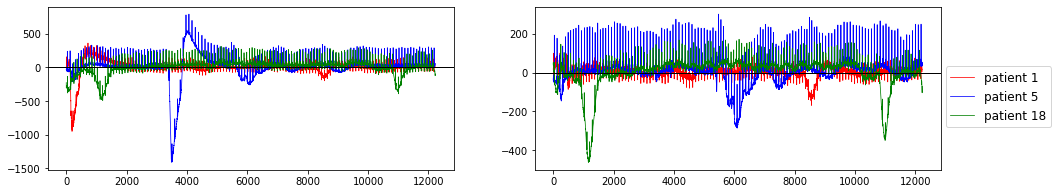

In [5]:
plot_all_ECG_results(ECG_data, patient_ids=(1,5,18))

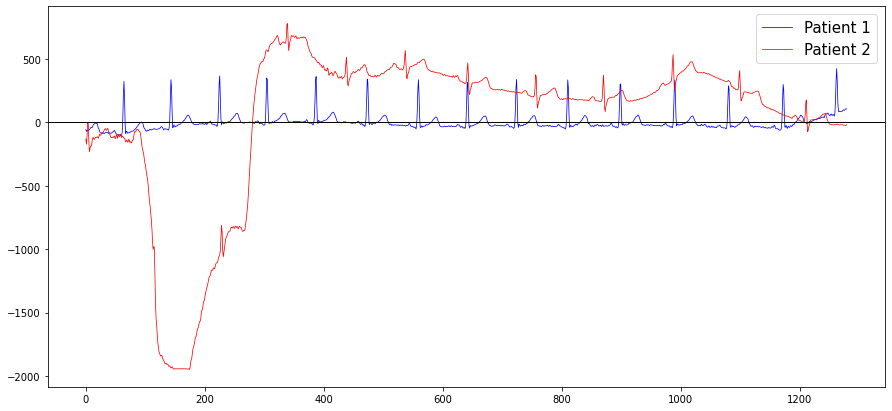

In [6]:
compare_two_ECG(ECG_data, patients=(3,6), time=(0,10), video=4, ECG=0)

In [7]:
extracted_data = extract_data(data=ECG_data, extract_time = 5)
baseline_data = calculate_mean_over_data(data=extracted_data)
trimmed_data = trim_data(data=ECG_data, start_trim=7)
trimmed_mean_data = calculate_mean_over_data(data=trimmed_data, calculation_frequency=1)
subtracted_data = subtract_baseline_from_data(data=trimmed_mean_data, baseline=baseline_data)
# scaled_data = zscore_normalize_data(data=subtracted_data)

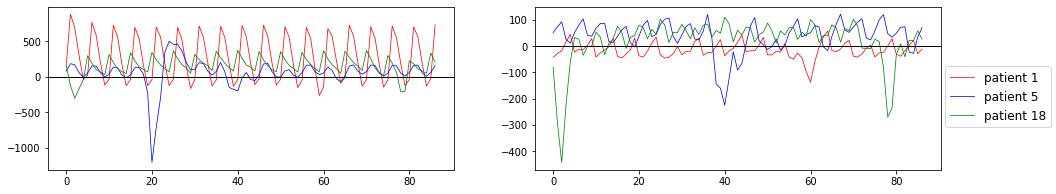

In [8]:
plot_all_ECG_results(subtracted_data, patient_ids=(1,5,18))

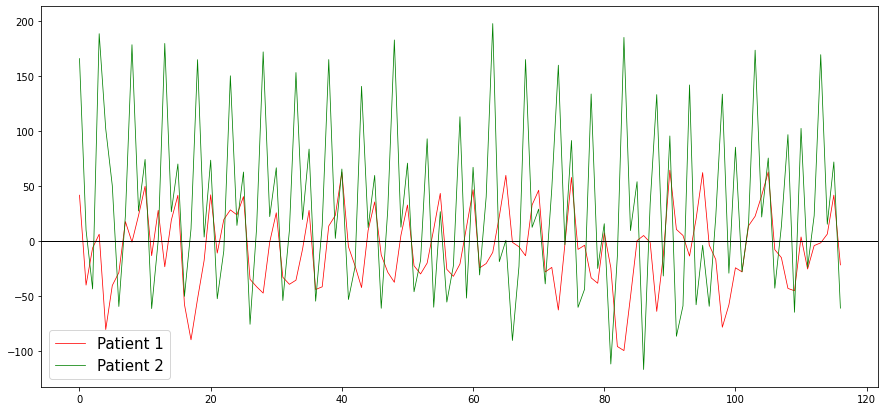

In [9]:
compare_two_ECG(subtracted_data, patients=(3,6), time=(0,60), video=4, ECG=1, colors=("r", "g"))

In [10]:
# Baseline data processing
extracted_data = extract_data(data=ECG_data, extract_time = 5)
baseline_data = calculate_mean_baseline(data=extracted_data)

# ECG main data processing
trimed_data = trim_data(data=ECG_data, start_trim=7)
splited_data = split_data_into_samples(data=trimed_data, sample_length=1)
del trimed_data
nobaseline_data = subtract_baseline_data(data=splited_data, baseline_data=baseline_data)
del splited_data
normalized_data = zscore_normalize_data(data=nobaseline_data)

100%|██████████| 33/33 [00:01<00:00, 22.78it/s]


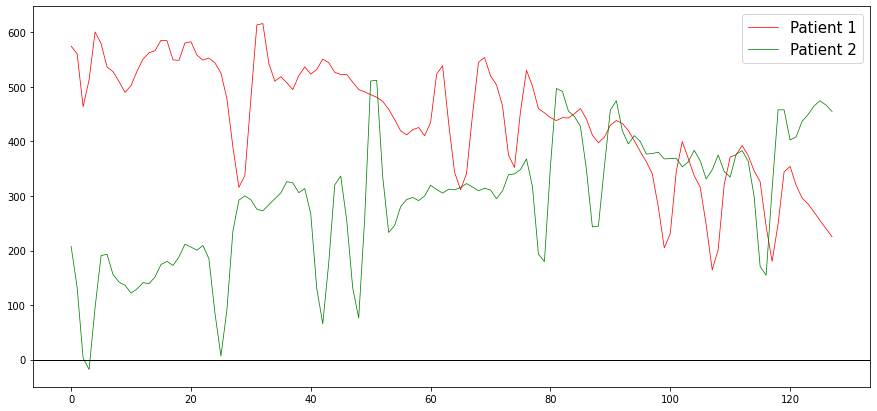

In [11]:
compare_two_samples(nobaseline_data, patients=(1,18), time=(0,1), video=4, ECG=0, sample=6, colors=("r", "g"))

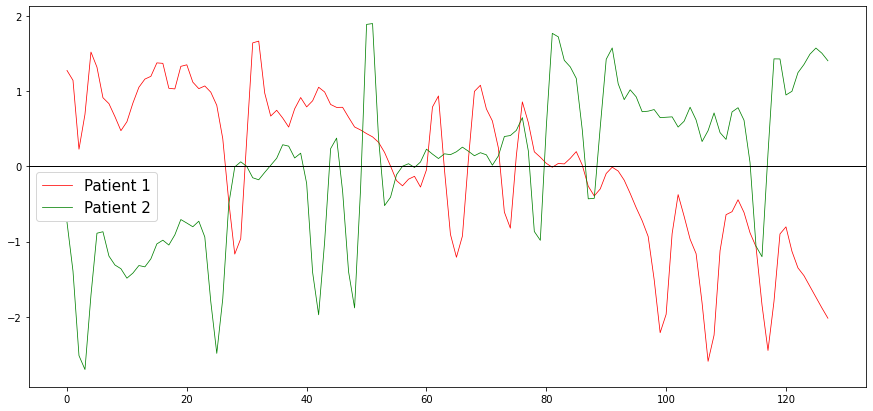

In [12]:
compare_two_samples(normalized_data, patients=(1,18), time=(0,1), video=4, ECG=0, sample=6, colors=("r", "g"))

# Store data in input and output arrays for neural network

In [14]:
#In the paper there are distinguished 4 classes and each samples belongs to one of them: 
#HVHA,HVLA,LVHA,LVLA (low,high,valence,arousal)

def assignTargetClass(y):
    output = np.array([1.,1.,1.,1.],dtype="float32")
    
    #valence:
    if y[0]<4.5:
        output *= [0.,0.,1.,1.]
    else:
        output *= [1.,1.,0.,0.]
        
    #arousal:
    if y[1]<4.5:
        output *= [0.,1.,0.,1.]
    else:
        output *= [1.,0.,1.,0.]
        
    
    return output
    

In [15]:
#Calculating total size of array, creating it once and indexing is faster than appending 2D array each time.
size =0 
for patient in normalized_data:
    for sample in patient:
        for second in sample:
            size +=1
    
#Create desired arrays.
x=np.empty((size,128,2))
y=np.empty((size,4,))  #one out of 4 classes
counter = 0
fail = 0 #sometimes samples are not consistent i.e. length!=128 (probably last second of recording) so we drop these



for i,patient in tqdm(enumerate(normalized_data)):
    for j,sample in enumerate(patient):
        for k,second in enumerate(sample):
            if not len(second) == 128:
                #print(i,j,k)
                fail +=1
                continue
            x[counter] = second            
            y[counter] = assignTargetClass(self_assesment_data[i][j])
            counter += 1
            
print("Failed "+str(fail))

33it [00:00, 64.63it/s]

Failed 516


In [16]:
#remove failed samples (empty records)
x = x[:-fail,:,:]
y = y[:-fail,:]

#show ready to learn dataset size
print(x.shape)
print(y.shape)
print("Example target vector: "+str(y[0]))

(42417, 128, 2)
(42417, 4)
Example target vector: [0. 0. 1. 0.]


Text(0.5, 1.0, 'Output class distribution')

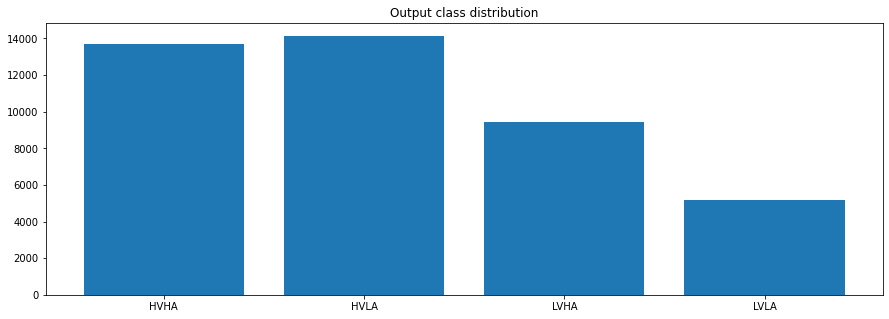

In [17]:
#lets take a look at output class distribution:
fig = plt.figure(figsize=(15,5))
axs = fig.add_subplot(111)
axs.bar(["HVHA","HVLA","LVHA","LVLA"], height=sum(y))
axs.set_title('Output class distribution')

In [18]:
from sklearn.model_selection import train_test_split

#restrict to only one ECG channel and force specific shape for network input
x = x[:,:,0].reshape(len(x),128,1)

#divide into train and validaton sets
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.30)

In [19]:
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers

#required to run on my GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.8
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


In [20]:
model = models.Sequential()
#in original paper some 'folding here'
model.add(layers.Conv1D(16, 3, activation='relu',padding="same", input_shape=(128,1)))
model.add(layers.MaxPooling1D(2,1,padding="same",))
model.add(layers.Conv1D(32, 3, activation='relu',padding="same"))
model.add(layers.MaxPooling1D(2,1,padding="same"))
#in original paper some 'unfolding here'
model.add(layers.Flatten())
model.add(layers.Reshape((-1,1)))
model.add(layers.LSTM(128,activation="tanh",recurrent_activation="sigmoid"))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4096, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               6

In [21]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99),
              loss='categorical_crossentropy',
              metrics=['acc'])


history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_validation, y_validation))

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/conv1d (defined at <ipython-input-21-bc8db09614f3>:9) ]] [Op:__inference_train_function_3517]

Function call stack:
train_function


# TO DO:
* ~~Remove first and last 2 seconds of the recording~~
* ~~Create baseline mean for the data (guess it's first 5 seconds of the video)~~
* ~~Subtract baseline recursively?? i guess by the pdf from the measurements~~
* ~~Z-score normalization~~ (average over sample or population?)
* create working NN
* train